# DNN Evaluation

In [61]:
channel = 'SL' # change this [DL or SL]

import os
import sys
from glob import glob
import random
import string
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
#plt.style.use('ggplot')
from collections import defaultdict
import ROOT
import copy
from pickle import load

### Read the dataframe with prediction from saved h5 file

In [83]:
h5_file = os.path.join(tagdir, 'dataframe_with_prediction.h5')
df_comb = pd.read_hdf(h5_file, "df")
print(f'Combined dataframe: keys -> {df_comb.keys()}\t shape -> {df_comb.shape}')

Combined dataframe: keys -> Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_tauh', 'dphi_lep_met',
       'dphi_tauh_met', 'pt_h3', 'dr_lep_h3', 'dr_tauh_h3',
       'dr_lep_tauh_x_pt_h3', 'dr_bjet1_bjet2', 'pt_ss2', 'dr_bjet1_ss2',
       'dr_bjet2_ss2', 'dr_bjet1_bjet2_x_pt_ss2', 'dr_lep_bjet1',
       'dr_lep_bjet2', 'dr_tauh_bjet1', 'dr_tauh_bjet2', 'dphi_bjet1_met',
       'dphi_bjet2_met', 'dr_bjet1_h3', 'dr_bjet2_h3', 'dr_lep_ss2',
       'dr_tauh_ss2', 'costhetaS_h3lep', 'costhetaS_ss2b', 'dr_min_alljets',
       'dr_max_alljets', 'smin', 'njets', 'nbjets', 'nljets', 'mass', 'tag',
       'wt', 'score'],
      dtype='object')	 shape -> (1601591, 43)


In [72]:
labelhistdict = {}
labelhistdictforplot = defaultdict(list)
nbins = 40
xmin  = 0.0
xmax  = 1.0
#scaler = load(open(os.path.join(tagdir,'scaler.pkl'), 'rb'))
for sample, info in dfs_dict.items():
    #print(sample, info[3])
    pdtonp = info[0].to_numpy()
    #print(pdtonp.shape)
    X_np = pdtonp[:,:pdtonp.shape[1]-1]
    X_test_scaled = scaler.transform(X_np) if scale else X_np
    #print(X_np.shape)
    Y_np = pdtonp[:,-1]
    #print(Y_np.shape)
    scores    = model.predict(X_test_scaled)
    #print(f'{sample} : {scores}')
    hname = 'pred_hist_'+sample
    hname = ROOT.TH1F(hname, "", nbins, xmin, xmax)
    #preds = list(scores[:,-1]) if sample == 'muta_lnu' else list(scores[:,1])
    preds = list(scores[:,-1])
    for item in preds:
        hname.Fill(item)
    #print(f'sample : {sample}, nRawEvents : {hname.Integral()}')
    hname.Scale(info[1]*lumi/info[2])
    #print(f' -- nLumiScaledEvents : {hname.Integral()}')
    labelhistdict[sample] = hname # for individual process 
    labelhistdictforplot[info[3]].append(hname)
    hname.SetDirectory(0)

# Get Significance

Significance at 80% signal efficiency : 11.757
Signal efficiency : (22, 0.796)
Bkg rejection : 0.903
sig eff : 0.5, bkg rej : 0.979, signif : 15.414
sig eff : 0.65, bkg rej : 0.957, signif : 14.065
sig eff : 0.8, bkg rej : 0.903, signif : 11.757
sig eff : 0.95, bkg rej : 0.655, signif : 7.507


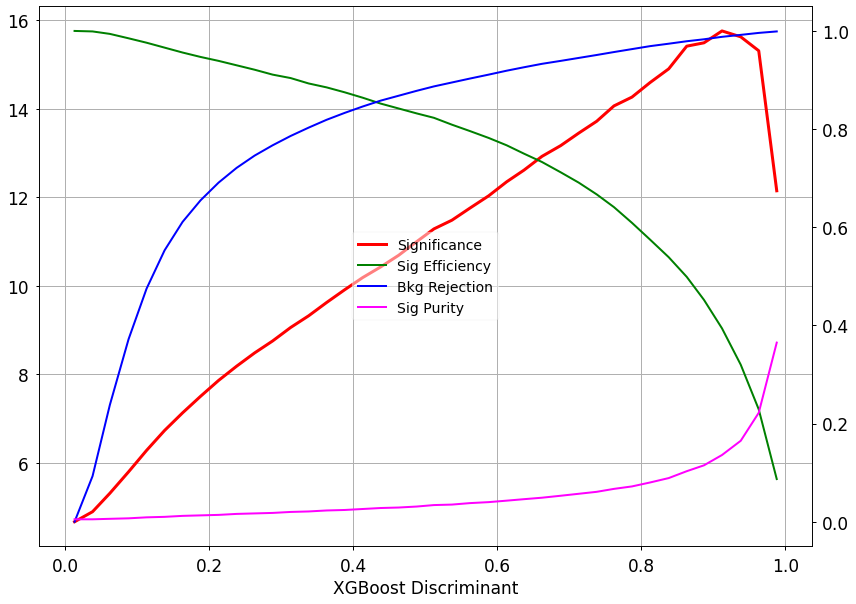

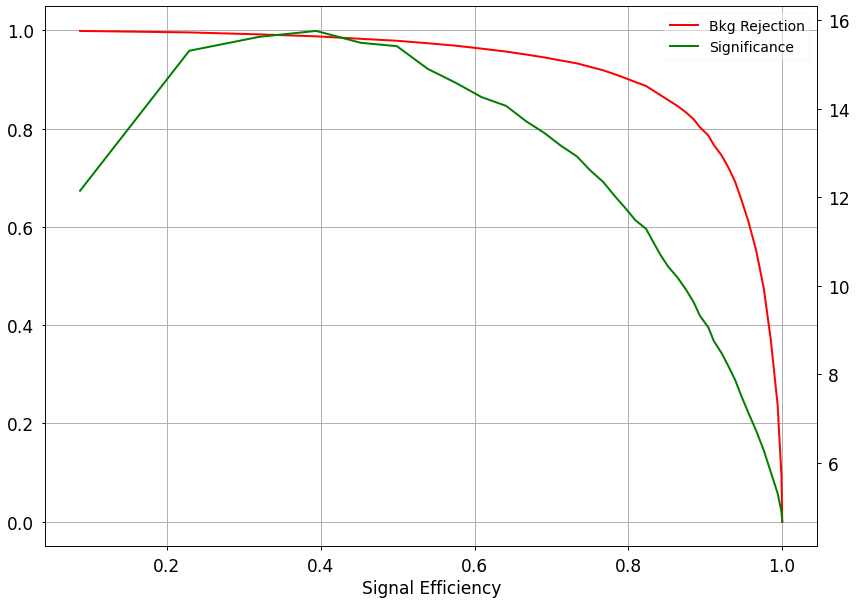

"\nfrom math import sqrt\nsignifs = []\nbdtscores = []\nhsig = labelhistdict.get('muta_lnu')\nfor i in range(nbins):\n    ibin = i+1\n    #print(f'bin > {ibin}')\n    nsig = hsig.Integral(ibin, nbins)\n    #print(f'nSignal : {nsig}')\n    nbkg = 0\n    #print('Bkg -->')\n    for j,(key, val) in enumerate(labelhistdict.items()):\n        if j == 0 : \n            continue\n        nbkg_ = val.Integral(ibin, nbins)\n        #print(f' >>--- proc : {key} --> {nbkg_}')\n        nbkg += nbkg_\n    if nsig+nbkg == 0:\n        continue\n    signif = nsig/sqrt(nsig+nbkg)\n    #print(f'total Bkg. {nbkg}')\n    #print(f'BDT score : {hsig.GetBinCenter(ibin)} , Significance. {signif}\n')\n    bdtscores.append(round(hsig.GetBinCenter(ibin),3))\n    signifs.append(round(signif,3))\n\n#print(signifs, len(signifs))   \n#print(bdtscores, len(bdtscores))\n\nplt.figure(figsize=(12,8.5))\nplt.plot(bdtscores, signifs, lw=3)\nplt.xlabel('DNN score', size=20)\nplt.ylabel('Significance', size=20)\nplt.title('s

In [73]:
from math import sqrt
signifs = []
sig_effs = []
sig_purs = []
bkg_rejs = []
bdtscores = []
hsig = labelhistdict.get('muta_lnu')
nSigEvents = hsig.Integral()
nBkgEvents = 0.0
for i in range(nbins):
    ibin = i+1
    #print(f'bin > {ibin}')
    nsig = hsig.Integral(ibin, nbins)
    #print(f'nSignal : {nsig}')
    nbkg = 0
    #print('Bkg -->')
    for j,(key, val) in enumerate(labelhistdict.items()):
        if j == 0 : 
            continue
        if i == 0 :
            nBkgEvents += val.Integral() 
        nbkg_ = val.Integral(ibin, nbins)
        #print(f' >>--- proc : {key} --> {nbkg_}')
        nbkg += nbkg_
    if nsig+nbkg == 0:
        continue
    sig_eff = nsig/nSigEvents
    bkg_rej = 1 - nbkg/nBkgEvents
    sig_pur = nsig/(nsig + nbkg)
    signif = nsig/sqrt(nsig+nbkg)
    #print(f'total Bkg. {nbkg}')
    #print(f'BDT score : {hsig.GetBinCenter(ibin)} , Significance. {signif}\n')
    bdtscores.append(round(hsig.GetBinCenter(ibin),3))
    signifs.append(round(signif,3))
    sig_effs.append(round(sig_eff, 3))
    bkg_rejs.append(round(bkg_rej, 3))
    sig_purs.append(round(sig_pur, 3))
    
sigeff70p = min(enumerate(sig_effs), key=lambda x: abs(x[1]-0.8))
#sigeff70p_idx = np.argmin(np.abs(np.array(sig_effs)-))
bkgrejatsigeff70p = bkg_rejs[sigeff70p[0]]
signfcatsigeff70p = signifs[sigeff70p[0]]

print(f'Significance at 80% signal efficiency : {signfcatsigeff70p}')
print(f'Signal efficiency : {sigeff70p}')
print(f'Bkg rejection : {bkgrejatsigeff70p}')

_sigeff = sigeff70p[1]
_bkgrej = bkgrejatsigeff70p
_signif = signfcatsigeff70p
_score  = bdtscores[sigeff70p[0]]
#print(signifs, len(signifs))   
#print(bdtscores, len(bdtscores))

for seff in [0.5,0.65,0.8,0.95]:
    sigeff_temp = min(enumerate(sig_effs), key=lambda x: abs(x[1]-seff))
    print(f'sig eff : {seff}, bkg rej : {bkg_rejs[sigeff_temp[0]]}, signif : {signifs[sigeff_temp[0]]}')
'''
plt.figure(figsize=(12,8.5))
plt.plot(bdtscores, signifs, lw=3)
plt.xlabel('XGBoost score', size=20)
plt.ylabel('Significance', size=20)
plt.title('s/sqrt(s+b) vs. BDT score', size=20)
plt.text(0.2, 2, f'max significance : {max(signifs)}\n at BDT_score : {bdtscores[signifs.index(max(signifs))]}', fontsize = 22)
plt.savefig(os.path.join(tagdir,'maxSignificance.png'),dpi=300)
plt.show()
'''
fig, ax = plt.subplots(figsize=(12,8.5))
#plt.grid(False)
ax = plt.gca()
l1,=ax.plot(bdtscores, signifs,  lw=3, color='red')
ax.grid(True)
ax.set_xlabel('XGBoost Discriminant', fontsize=17)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)

ax2 = ax.twinx()
l2,=ax2.plot(bdtscores, sig_effs, lw=2, color='green')
l3,=ax2.plot(bdtscores, bkg_rejs, lw=2, color='blue')
l4,=ax2.plot(bdtscores, sig_purs, lw=2, color='magenta')
ax2.grid(False)
ax2.tick_params(axis='y', labelsize=17)

plt.legend([l1, l2, l3, l4],
           ["Significance", "Sig Efficiency", "Bkg Rejection", "Sig Purity"], 
           loc='best',
           fontsize=14,
           fancybox=True,
           framealpha=0.5)
fig.tight_layout()
#plt.text(0.4,0.8,f'max significance : {max(signifs)}\n score > {bdtscores[signifs.index(max(signifs))]}\n sig eff : {sig_effs[signifs.index(max(signifs))]}\n bkg rej : {bkg_rejs[signifs.index(max(signifs))]}', fontsize = 22)
#plt.text(-0.5,0.3,f'significance at 80% sigeff: {_signif}\n at BDT_score : {_score}\n sig eff : {_sigeff}\n bkg rej : {_bkgrej}', fontsize = 22)
plt.savefig(os.path.join(tagdir,'maxSignificance.png'),dpi=300)
plt.savefig(os.path.join(tagdir,'maxSignificance.pdf'),dpi=300)
plt.show()

#plt.clf()
#plt.figure(figsize=(12,8.5))
#plt.plot(sig_effs, bkg_rejs,  lw=3)
#plt.plot(sig_effs, signifs, lw=3)
#plt.show()

fig, ax = plt.subplots(figsize=(12,8.5))
#plt.grid(False)
ax = plt.gca()
l1,=ax.plot(sig_effs, bkg_rejs,  lw=2, color='red')
ax.grid(True)
ax.set_xlabel('Signal Efficiency', fontsize=17)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)

ax2 = ax.twinx()
l2,=ax2.plot(sig_effs, signifs, lw=2, color='green')
ax2.grid(False)
ax2.tick_params(axis='y', labelsize=17)

plt.legend([l1, l2, l3, l4],
           ["Bkg Rejection", "Significance"], 
           loc='best',
           fontsize=14,
           fancybox=True,
           framealpha=0.5)
fig.tight_layout()
#plt.text(0.8,0.4,f'max significance : {max(signifs)} \n  sig eff : {sig_effs[signifs.index(max(signifs))]}\n  bkg rej : {bkg_rejs[signifs.index(max(signifs))]}', fontsize = 22)
plt.savefig(os.path.join(tagdir,'ROCwithSignificance.png'),dpi=300)
plt.savefig(os.path.join(tagdir,'ROCwithSignificance.pdf'),dpi=300)
plt.show()

'''
from math import sqrt
signifs = []
bdtscores = []
hsig = labelhistdict.get('muta_lnu')
for i in range(nbins):
    ibin = i+1
    #print(f'bin > {ibin}')
    nsig = hsig.Integral(ibin, nbins)
    #print(f'nSignal : {nsig}')
    nbkg = 0
    #print('Bkg -->')
    for j,(key, val) in enumerate(labelhistdict.items()):
        if j == 0 : 
            continue
        nbkg_ = val.Integral(ibin, nbins)
        #print(f' >>--- proc : {key} --> {nbkg_}')
        nbkg += nbkg_
    if nsig+nbkg == 0:
        continue
    signif = nsig/sqrt(nsig+nbkg)
    #print(f'total Bkg. {nbkg}')
    #print(f'BDT score : {hsig.GetBinCenter(ibin)} , Significance. {signif}\n')
    bdtscores.append(round(hsig.GetBinCenter(ibin),3))
    signifs.append(round(signif,3))

#print(signifs, len(signifs))   
#print(bdtscores, len(bdtscores))

plt.figure(figsize=(12,8.5))
plt.plot(bdtscores, signifs, lw=3)
plt.xlabel('DNN score', size=20)
plt.ylabel('Significance', size=20)
plt.title('s/sqrt(s+b) vs. DNN score', size=20)
plt.text(0.4, 4.5, f'max significance : {max(signifs)}\n at BDT_score : {bdtscores[signifs.index(max(signifs))]}', fontsize = 22)
plt.savefig(os.path.join(tagdir,'maxSignificance.png'),dpi=300)
plt.show()
'''

"\ncanv2.cd()\ncanv2.SetLogy()\nstack.Draw('nostack hist')\nstack.GetXaxis().SetTitle('DNN Response')\nstack.GetYaxis().SetTitle('Normalised events')\nlegn.Draw()\ncanv2.Update()\n#canv2.SetGrid()\ncanv2.SaveAs(os.path.join(tagdir,'DNN_Discriminator_logy.png'))\ncanv2.SaveAs(os.path.join(tagdir,'DNN_Discriminator_logy.pdf'))\ncanv2.Draw()\n"

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /home/gsaha/Work/DelphesML/Project2/DNN/DL_MX_60_Final/DNN_Discriminator.png has been created
Info in <TCanvas::Print>: pdf file /home/gsaha/Work/DelphesML/Project2/DNN/DL_MX_60_Final/DNN_Discriminator.pdf has been created


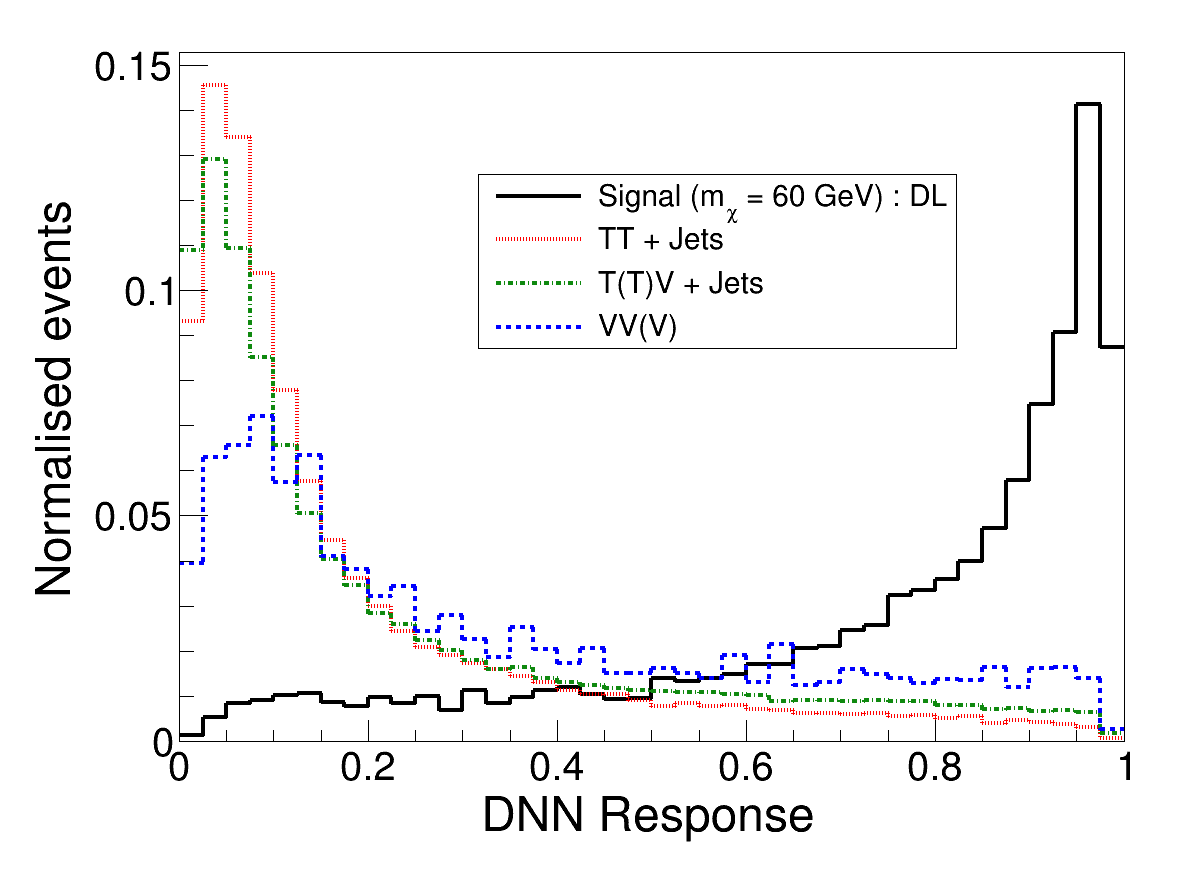

In [74]:
stack = ROOT.THStack()
canv  = ROOT.TCanvas('c','',1200,900)
#canv2 = ROOT.TCanvas('c2','',800,600)
#if usenorm:
#    ROOT.gPad.SetLogy()

legn  = ROOT.TLegend(0.4,0.6,0.8,0.8)

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.06)
ROOT.gPad.SetTopMargin(0.06)
ROOT.gPad.SetBottomMargin(0.15)    


for idx, (label, histList) in enumerate(labelhistdictforplot.items()):
    if len(histList) == 0:
        continue
    hist = histList[0]
    if len(histList) > 1:
        for i,hist_ in enumerate(histList):
            if i == 0: continue
            hist.Add(hist_)
    if usenorm:
        hist_ = copy.deepcopy(hist)
        hist_.Scale(1/hist_.Integral())
    idx_ = idx
    if idx == 2 : idx_ = 208
    hist_.SetLineColor(idx_+1)
    hist_.SetLineWidth(4)
    hist_.SetLineStyle(2*idx+1)
    #hist_.SetFillColorAlpha(idx+1,0.3)
    legn.AddEntry(hist_, label, 'l')
    stack.Add(hist_)


canv.cd()
stack.Draw('nostack hist')
stack.GetXaxis().SetNdivisions(505)
stack.GetYaxis().SetNdivisions(505)
stack.GetXaxis().SetLabelSize(0.05)
stack.GetYaxis().SetLabelSize(0.05)
stack.GetXaxis().SetTitle('DNN Response')
stack.GetXaxis().CenterTitle(True)
stack.GetXaxis().SetTitleSize(0.06)
stack.GetYaxis().SetTitle('Normalised events')
stack.GetYaxis().CenterTitle(True)
stack.GetYaxis().SetTitleSize(0.06)
stack.GetXaxis().SetTitleOffset(0.92)
stack.GetYaxis().SetTitleOffset(1.1)
legn.Draw()
canv.Update()
#canv.SetGrid()
canv.SaveAs(os.path.join(tagdir,'DNN_Discriminator.png'))
canv.SaveAs(os.path.join(tagdir,'DNN_Discriminator.pdf'))
canv.Draw()

'''
canv2.cd()
canv2.SetLogy()
stack.Draw('nostack hist')
stack.GetXaxis().SetTitle('DNN Response')
stack.GetYaxis().SetTitle('Normalised events')
legn.Draw()
canv2.Update()
#canv2.SetGrid()
canv2.SaveAs(os.path.join(tagdir,'DNN_Discriminator_logy.png'))
canv2.SaveAs(os.path.join(tagdir,'DNN_Discriminator_logy.pdf'))
canv2.Draw()
'''